# Takeaways
* Transforming a Series into a row vector - `a = a.reshape((len(a), -1))`

# Recurrent Neural Networks
* A neural net architecture specifically designed for learning sequential data - like text and time series data.
* Again, using Keras
* Recurrent neural networks **maintain a memory** - each layer has some knowledge about the steps it has previously seen as the next step hits.
* When we talk about **fully unfolding an RNN**, we're talking about looking at the contribution of each timestep to the weights of the tensor in that layer.

import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
from pprint import pprint
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense
plt.style.use('seaborn')
pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)

In [2]:
import tensorflow.compat.v1 as tf
tf.logging.set_verbosity(tf.logging.ERROR)

//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
def set_seeds(seed=100):
    random.seed(seed)
    tf.random.set_random_seed(seed)
    np.random.seed(seed)

In [6]:
set_seeds()

In [7]:
a = np.arange(100)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [10]:
a = a.reshape((len(a), -1)) # 100 rows, 1 column
a.shape 

(100, 1)

# RNN Bootstrapping
* Use the Keras `TimeseriesGenerator` to transform time series data into raw material for training the RNN
* The idea here is to used lagged time series data to teach the network to predict the next value

In [21]:
lags = 3
g = TimeseriesGenerator(a, a, length=lags, batch_size=5)

In [22]:
pprint(list(g)[0]) # 5 periods of a 3-period window

(array([[[0],
        [1],
        [2]],

       [[1],
        [2],
        [3]],

       [[2],
        [3],
        [4]],

       [[3],
        [4],
        [5]],

       [[4],
        [5],
        [6]]]),
 array([[3],
       [4],
       [5],
       [6],
       [7]]))


In [23]:
model = Sequential()
model.add(SimpleRNN(100, activation='relu',
                  input_shape=(lags, 1)))
model.add(Dense(1, activation='linear')) # Linear output layer
model.compile(optimizer='adagrad', loss='mse', metrics=['mae'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [25]:
%%time
model.fit_generator(g, epochs=1000, steps_per_epoch=5, verbose=False)

CPU times: user 25.3 s, sys: 3.35 s, total: 28.7 s
Wall time: 17.7 s


In [26]:
res = pd.DataFrame(model.history.history)

In [27]:
res.tail(3)

,loss,mae
997,1.1412,0.9720
998,1.3113,0.9942
999,0.3049,0.5194


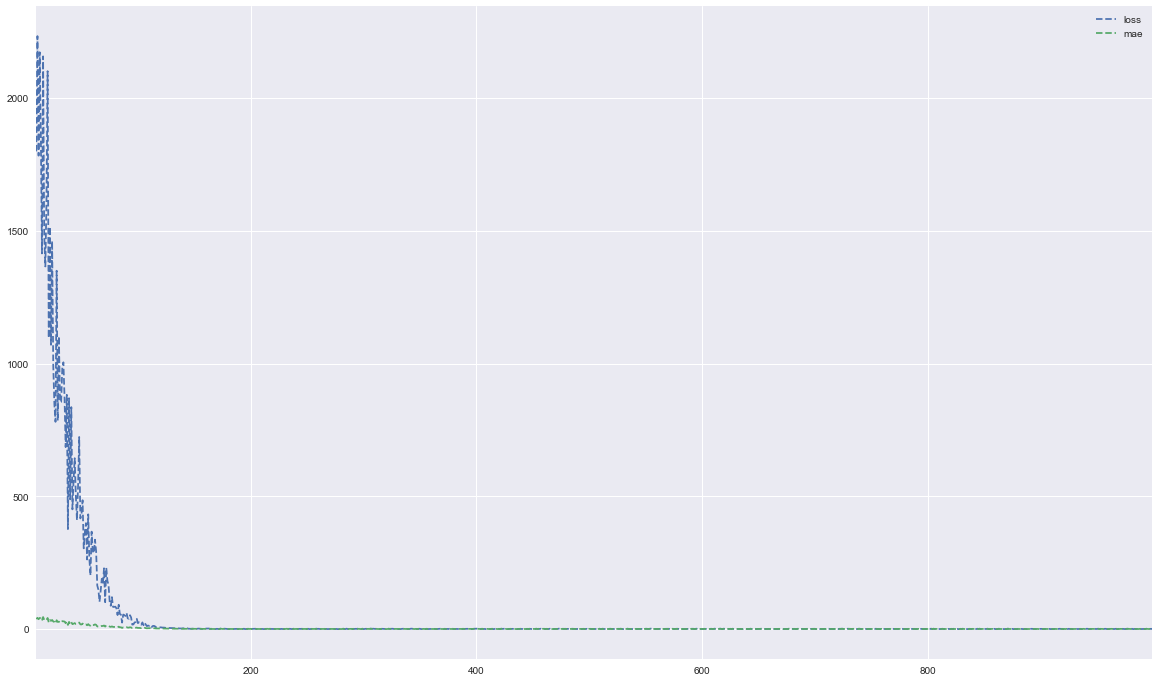

In [31]:
res.iloc[10:].plot(figsize=(20,12), style=['--', '--']) # Spiky erratic training

In [38]:
# RNN is now trained - generate prediction for "next value" from this
x = np.array([21,22,23]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0])) # Not great!

23

In [75]:
'''
Three dimensions: 1 x 3 x 1 - each value is contained in the 1 of each of the 3, which is contained in the 1
'''
x = np.array([87, 88, 89]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

91

In [78]:
x = np.array([187, 188, 189]).reshape((1, lags, 1))
y = model.predict(x, verbose=False) 
int(round(y[0, 0]))

193

In [79]:
x = np.array([1187, 1188, 1189]).reshape((1, lags, 1))
y = model.predict(x, verbose=False)
int(round(y[0, 0]))

1220

# A More Sophisticated Example
* Next, we'll train an rnn on data that has a trigonmetric shape but is heavily noised by a quadratic term.

In [98]:
def transform(x):
    y = 0.05 * x ** 2 + 0.2 * x + np.sin(x) + 5
    y += np.random.standard_normal(len(x)) * 0.2 # Noise-ing
    return y

In [99]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 500)
a = transform(x)

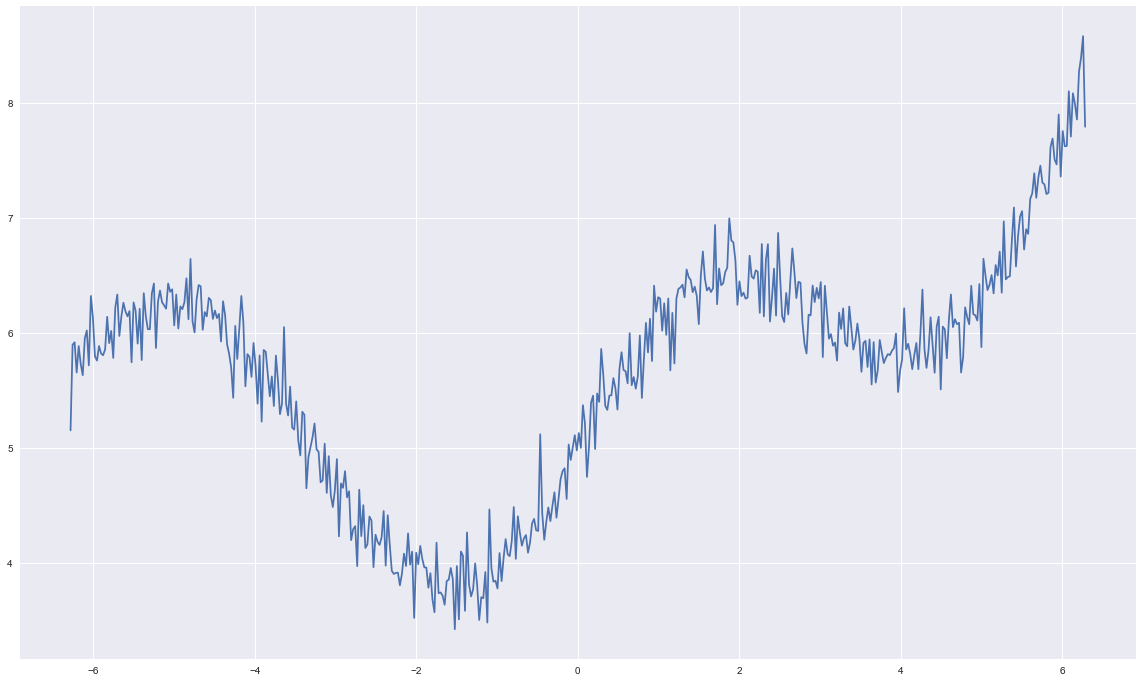

In [100]:
plt.figure(figsize=(20, 12))
plt.plot(x, a)

In [101]:
a.shape # We need to make this series into a matrix, albeit a 500 row 1 column one - so…

(500,)

In [102]:
# We do this
a = a.reshape((len(a), -1))
a.shape

(500, 1)

In [103]:
lags = 5
g = TimeseriesGenerator(a, a, length=lags, batch_size=5)

In [104]:
model = Sequential()
model.add(SimpleRNN(500, activation='relu', input_shape=(lags, 1)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 500)               251000    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 251,501
Trainable params: 251,501
Non-trainable params: 0
_________________________________________________________________


In [105]:
%%time
model.fit_generator(g, epochs=500, steps_per_epoch=10, verbose=False)

CPU times: user 54.5 s, sys: 10.3 s, total: 1min 4s
Wall time: 28.1 s


In [106]:
x2 = np.linspace(-6 * np.pi, 6 * np.pi, 1000) # Enlarged version to test on
d = transform(x2)

In [107]:
g_ = TimeseriesGenerator(d, d, length=lags, batch_size=len(d))

In [109]:
f = list(g_)[0][0].reshape((len(d) - lags, lags, 1))
f.shape # Need to understand why this reshape

(995, 5, 1)